### (OPTIONAL CELL BELOW) For copying dataset files from google drive. Alternatively, directly upload files on colab
1. mounting google drive 
2. copying dataset file from drive
3. unzipping the dataset file 

In [1]:
# 1. mounting google drive  
from google.colab import drive 
drive.mount('/content/drive/')

# 2. copying dataset file from drive
# update the source folder location as per your system
!cp '/content/drive/MyDrive/Codementor/Michael_CNN_FacialExpressionClassification/CW_Dataset.zip' CW_Dataset.zip 

# 3. unzipping the dataset file 
!unzip -qq CW_Dataset.zip

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
replace __MACOSX/._CW_Dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Importing required libraries, loading the dataset, printing dataset info and visualizing examples from the dataset

In [1]:
# importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
import torch 
import torchvision 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.optim as optim

# setting random seed for pytorch and numpy for reproducible results
torch.manual_seed(10)
np.random.seed(0)


In [2]:
# specifying folder paths for training and testing datasets
train_imgs_folderpath   = 'CW_Dataset/train/'
train_labels_folderpath = 'CW_Dataset/labels/list_label_train.txt'
test_imgs_folderpath    = 'CW_Dataset/test/'
test_labels_folderpath  = 'CW_Dataset/labels/list_label_test.txt'

In [3]:
# specifying the emotions related to the labels
label_to_emotion = { 1:'Surprise' , 2:'Fear' , 3:'Disgust' , 4:'Happiness' , 5:'Sadness', 6:'Anger', 7:'Neutral'  } # here the labels are before encoding . After encoding 1 maps to 0, 2 to 1 and so on

In [4]:
# Example filenames in list_label_train.txt are like train_00001.jpg
# However, actual filenames for the images are like train_00001_aligned.jpg 
# So, also performing the above conversion when saving the filenames in a list for both training and testing set filename

# Reading training set filenames and corresponding labels from train_labels_folderpath
train_filenames_fromlabelsfile = []
train_labels                   = []
content = open(train_labels_folderpath).read().split('\n')
for entry in content :
    filename, label = entry.split()
    train_filenames_fromlabelsfile.append(filename)
    train_labels.append(int(label))

# converting training set filenames from names like train_00001.jpg to train_00001_aligned.jpg 
train_filenames = []
for filename in train_filenames_fromlabelsfile :
  name, extension = filename.split('.')
  updated_name = name + '_aligned' + '.' + extension
  train_filenames.append(updated_name)


# Reading testing set filenames and corresponding labels from test_labels_folderpath
test_filenames_fromlabelsfile = []
test_labels                   = []
content = open(test_labels_folderpath).read().split('\n')
for entry in content :
    filename, label = entry.split()
    test_filenames_fromlabelsfile.append(filename)
    test_labels.append(int(label))

# converting testing set filenames from names like test_0001.jpg to test_0001_aligned.jpg 
test_filenames = []
for filename in test_filenames_fromlabelsfile :
  name, extension = filename.split('.')
  updated_name = name + '_aligned' + '.' + extension
  test_filenames.append(updated_name)


In [5]:
# printing statistics for training and testing set filenames and labels 
print("Total number of training image files: {}".format(len(train_filenames)))
print("Sample training image filename: {}".format(train_filenames[0]))
train_labels_unique , train_labels_unique_count = np.unique(train_labels, return_counts=True)
print("Count and unique labels values in the training set: Values:{} , Counts:{}".format(train_labels_unique, train_labels_unique_count))

print("")
print("Total number of testing image files: {}".format(len(test_filenames)))
print("Sample testing image filename: {}".format(test_filenames[0]))
test_labels_unique , test_labels_unique_count = np.unique(test_labels, return_counts=True)
print("Count and unique labels values in the testing set: Values:{} , Counts:{}".format(test_labels_unique, test_labels_unique_count))


Total number of training image files: 12271
Sample training image filename: train_00001_aligned.jpg
Count and unique labels values in the training set: Values:[1 2 3 4 5 6 7] , Counts:[1290  281  717 4772 1982  705 2524]

Total number of testing image files: 3068
Sample testing image filename: test_0001_aligned.jpg
Count and unique labels values in the testing set: Values:[1 2 3 4 5 6 7] , Counts:[ 329   74  160 1185  478  162  680]


In [6]:
# Converting labels to integer coded representation (label values starting from 0). labels are also converted from lists to numpy arrays
le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
test_labels_encoded  = le.transform(test_labels)

# printing sample label and it's one hot encoded representation 
print("Sample label {} , corresponding label/integer encoding: {}".format(train_labels[0], train_labels_encoded[0]))
print("Shape of train_labels_encoded: {} , Shape of test_labels_encoded: {}".format(train_labels_encoded.shape, test_labels_encoded.shape))

Sample label 5 , corresponding label/integer encoding: 4
Shape of train_labels_encoded: (12271,) , Shape of test_labels_encoded: (3068,)


In [7]:
# loading train and test set images and storing as numpy arrays 
train_imgs = [mpimg.imread(train_imgs_folderpath + filename) for filename in train_filenames]
train_imgs = np.array(train_imgs)
test_imgs = [mpimg.imread(test_imgs_folderpath + filename) for filename in test_filenames]
test_imgs = np.array(test_imgs)

print("Shape of train_imgs: {} , shape of test_imgs: {}".format(train_imgs.shape, test_imgs.shape))
print("train_imgs min,max values: {},{} , test_imgs min,max values: {},{}".format(np.min(train_imgs), np.max(train_imgs) , np.min(test_imgs), np.max(test_imgs) ))

Shape of train_imgs: (12271, 100, 100, 3) , shape of test_imgs: (3068, 100, 100, 3)
train_imgs min,max values: 0,255 , test_imgs min,max values: 0,255


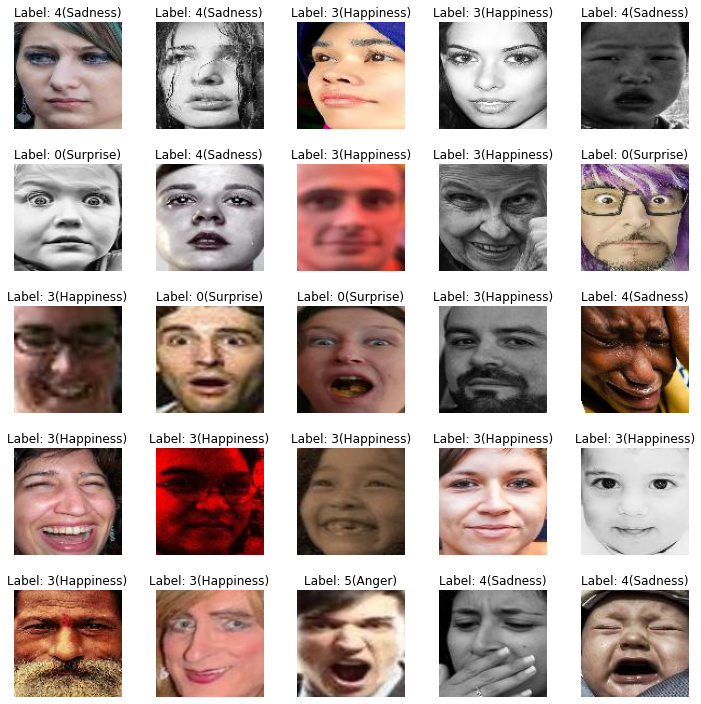

In [8]:
num_rows = 5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

idxs = np.random.choice( len(train_imgs), (num_rows*num_cols,) )
for i, idx in enumerate(idxs):
  ax[i].imshow(train_imgs[i])
  ax[i].set_title('Label: {}({})'.format(train_labels_encoded[i], label_to_emotion[train_labels[i]]))
  ax[i].set_axis_off()
fig.tight_layout()
plt.show()

### Defining custom dataset class for drawing (x,y) samples where x is the preprocessed image and y is the corresponding label. Also setting up pytorch dataloaders for train and test sets 
1. This approach also helps with more efficient data usage 

In [9]:
# defining custom dataset class for drawing (x,y) samples where x is the preprocessed image and y is the corresponding label. 
class createDataset(Dataset) :
  def __init__(self, imgs_arr, labels_arr):
    super(createDataset, self).__init__()
    self.imgs_arr   = imgs_arr
    self.labels_arr = labels_arr 
    
    # transforms.ToTensor() transformation converts numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    self.transform = transforms.ToTensor() 

  def __getitem__(self, index):
    x = self.imgs_arr[index]
    x = self.transform(x)
    y = self.labels_arr[index]
    y = torch.tensor(y)
    return x,y

  def __len__(self):
    return len(self.labels_arr)


In [10]:
# creating train and test datasets
train_dataset = createDataset(train_imgs, train_labels_encoded)
test_dataset  = createDataset(test_imgs, test_labels_encoded)

In [11]:
# setting some hyperparameters
train_batch_size = 64
test_batch_size  = 64

In [12]:
# creating train and test set dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

torch.Size([64, 3, 100, 100]) torch.Size([64])
tensor(0.) tensor(1.)


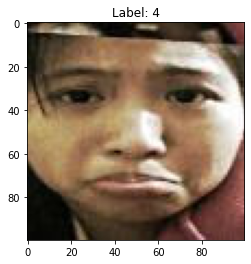

In [13]:
# visualizing a sample image from the dataset (also, for verifying correctness of the dataloader)
sample_imgs, sample_labels = next(iter(test_dataloader))
print(sample_imgs.shape, sample_labels.shape)
print(torch.min(sample_imgs), torch.max(sample_imgs))
sample_img = sample_imgs[0].permute(1,2,0)
sample_label = sample_labels[0]
plt.imshow(sample_img)
plt.title("Label: {}".format(sample_label))
plt.show()

### Defining CNN model architecture

In [14]:
class cnn_model(nn.Module):
  def __init__(self, num_classes=7) :
    super(cnn_model, self).__init__()
    self.num_classes = num_classes
    self.base_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 64),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 64),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),

        )
    
    self.classifier_layer = nn.Sequential(
        nn.Linear(in_features= 2304, out_features= 256), # updated number of out_features
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features= 256),  # updated number of num_features
        nn.Dropout(0.5),  
        nn.Linear( in_features= 256, out_features= self.num_classes)    # updated number of in_features
        )      
        
  def forward(self,x) :
    x = self.base_layer(x)
    x = x.reshape(x.size(0),-1)
    out = self.classifier_layer(x)
    return out


# 1. Setting training hyperparameters, optimizer, loss function, etc 
# 2. Training the model 

In [15]:
# setting up training parameters

# setting device to be gpu/cuda or cpu
device  = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Device used is {}".format(device))

# # set up model for training 
model = cnn_model()
model.train() 
model.to(device) # send model to device/GPU for training 

# defining loss to be CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Device used is cuda


In [16]:
# defining function for computing the test loss and test accuracy 
def test_loss_acc(test_dataloader, model) : 
  
  # set model in evaluation/testing mode
  model.eval() 

  # initializing batch losses and accuracies
  batch_losses = []
  batch_accuracies = []

  with torch.no_grad():
    for (x,y) in test_dataloader :
      # number of samples in the batch (last sample may have less than batch_size number of samples)
      num_samples = y.size(0)

      # send x,y to GPU
      x = x.to(device)
      y = y.to(device)

      # computing forward pass, loss and accuracy 
      output = model(x)
      loss   = criterion(output,y)
      batch_losses.append(loss.item())

      _, pred_labels = torch.max(output, dim=1)
      acc = (y == pred_labels).sum()/num_samples
      batch_accuracies.append(acc.item())

  test_loss     = sum(batch_losses)/len(batch_losses)
  test_accuracy = sum(batch_accuracies)/len(batch_accuracies)

  return test_loss, test_accuracy


In [17]:
num_epochs = 10
train_losses     = []
train_accuracies = []
test_losses      = []
test_accuracies  = []

for i in range(num_epochs):
  batch_losses = []
  batch_accuracies = []

  for t, (x,y) in enumerate(train_dataloader) :
    # number of samples in the batch (last sample may have less than batch_size number of samples)
    num_samples = y.size(0)

    # send x,y to GPU
    x = x.to(device)
    y = y.to(device)

    # computing forward pass, loss and accuracy 
    output = model(x)
    loss   = criterion(output,y)
    batch_losses.append(loss.item())

    _, pred_labels = torch.max(output, dim=1)
    acc = (y == pred_labels).sum()/num_samples
    batch_accuracies.append(acc.item())

    # computing backward pass and updating model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # printing train loss and train accuracy 
    if t%100 == 0 :
      print("Epoch {}, Iteration {}, loss = {:.4f}, acc = {:.2f}".format(i+1,t+1,loss.item(), acc.item()))

  train_losses.append( sum(batch_losses)/len(batch_losses) )
  train_accuracies.append( sum(batch_accuracies) / len(batch_accuracies) )

  test_loss, test_accuracy = test_loss_acc(test_dataloader, model)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print("After epoch {}, train loss = {}, train acc = {}, test loss = {}, test acc = {}".format(i+1, train_losses[-1], train_accuracies[-1], test_loss, test_accuracy ))
  print("*"*30)


Epoch 1, Iteration 1, loss = 2.2192, acc = 0.14
Epoch 1, Iteration 101, loss = 1.2918, acc = 0.56
After epoch 1, train loss = 1.4676947534705203, train acc = 0.48608744734277326, test loss = 1.0549330314000447, test acc = 0.6403211814661821
******************************
Epoch 2, Iteration 1, loss = 0.9964, acc = 0.73
Epoch 2, Iteration 101, loss = 0.9572, acc = 0.67
After epoch 2, train loss = 1.0243016220629215, train acc = 0.6391549616431197, test loss = 0.8763523530215025, test acc = 0.6975477437178293
******************************
Epoch 3, Iteration 1, loss = 0.9785, acc = 0.62
Epoch 3, Iteration 101, loss = 0.7466, acc = 0.77
After epoch 3, train loss = 0.7640820384646455, train acc = 0.7287476450825731, test loss = 0.7757235113531351, test acc = 0.7195746538539728
******************************
Epoch 4, Iteration 1, loss = 0.7291, acc = 0.73
Epoch 4, Iteration 101, loss = 0.8707, acc = 0.66
After epoch 4, train loss = 0.8085220516659319, train acc = 0.7128040501847863, test los

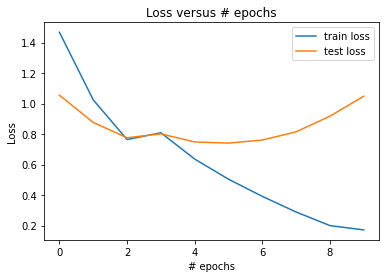

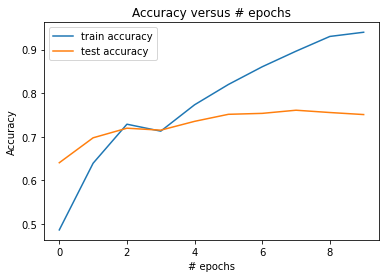

In [18]:
# plotting the train and test set losses and accuracies
epochs = np.arange(num_epochs)

plt.title("Loss versus # epochs")
plt.ylabel("Loss")
plt.xlabel("# epochs")
plt.plot(epochs, train_losses, label='train loss')
plt.plot(epochs, test_losses, label='test loss')
plt.legend()

plt.figure()
plt.title("Accuracy versus # epochs")
plt.ylabel("Accuracy")
plt.xlabel("# epochs")
plt.plot(epochs, train_accuracies, label='train accuracy')
plt.plot(epochs, test_accuracies, label='test accuracy')
plt.plot()
plt.legend()

plt.show()

### Performing inference/predictions on the trained model 

In [19]:
# defining function to get the predicted labels from the trained model 
def get_pred_label(model, img):
  img = img.copy()
  img_tensor = torch.from_numpy(img)
  img_tensor = img_tensor/255.
  img_tensor = torch.unsqueeze(img_tensor, 0)
  img_tensor = img_tensor.permute(0,3,1,2)
  img_tensor = img_tensor.to(device)
  model.eval() # set model to evaluation mode 
  output = model(img_tensor)
  _, pred_label = torch.max(output, dim=1)
  return pred_label[0].item()


In [20]:
# getting model predictions on training set
num_samples = len(train_imgs)
preds_train = []
for i in range(num_samples) :
  pred = get_pred_label(model, train_imgs[i])
  preds_train.append(pred)


In [21]:
# getting model predictions on testing set
num_samples = len(test_imgs)
preds_test = []
for i in range(num_samples) :
  pred = get_pred_label(model, test_imgs[i])
  preds_test.append(pred)

In [22]:
# printing accuracy scores 
acc_train = accuracy_score(train_labels_encoded, preds_train)
acc_test  = accuracy_score(test_labels_encoded, preds_test)
print("Train accuracy: {}, Test accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.9396952163637845, Test accuracy: 0.7509778357235984


In [23]:
# printing confusion matrix for the test set
print("Confusion matrix ")
confusion_matrix(test_labels_encoded, preds_test)

Confusion matrix 


array([[ 252,    3,    6,   19,   12,    3,   34],
       [  17,   22,    1,   11,    9,    5,    9],
       [   6,    1,   49,   19,   16,    9,   60],
       [  20,    4,    8, 1038,   17,    9,   89],
       [  13,    3,   17,   43,  304,   14,   84],
       [   9,    2,    9,   14,    8,  102,   18],
       [  32,    0,   19,   28,   57,    7,  537]])

In [24]:
# printing classification report 
print("Classification report")
print(classification_report(test_labels_encoded , preds_test))

Classification report
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       329
           1       0.63      0.30      0.40        74
           2       0.45      0.31      0.36       160
           3       0.89      0.88      0.88      1185
           4       0.72      0.64      0.67       478
           5       0.68      0.63      0.66       162
           6       0.65      0.79      0.71       680

    accuracy                           0.75      3068
   macro avg       0.68      0.61      0.63      3068
weighted avg       0.75      0.75      0.75      3068



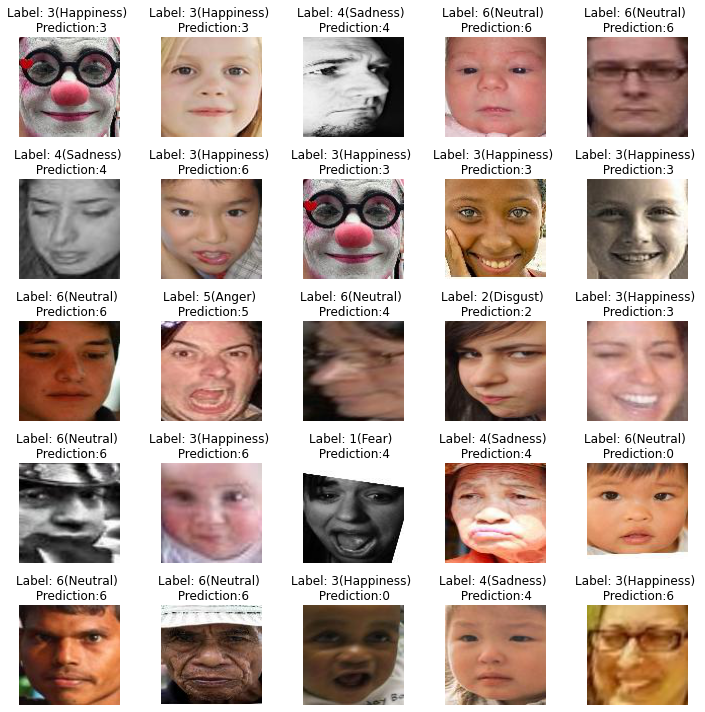

In [25]:
# visualizing the predictions 

num_rows = 5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

idxs = np.random.choice( len(test_imgs), (num_rows*num_cols,) )
for i, idx in enumerate(idxs):
  ax[i].imshow(test_imgs[idx])
  ax[i].set_title('Label: {}({}) \n Prediction:{}'.format(test_labels_encoded[idx], label_to_emotion[test_labels[idx]], preds_test[idx]))
  ax[i].set_axis_off()
fig.tight_layout()
plt.show()


In [26]:
# saving the model 
model_filepath = 'model.pth'
torch.save(model.state_dict(), model_filepath)

In [31]:
# defining the Emotion Recognition function 
test_imgs_folderpath    = 'CW_Dataset/test/'
label_to_emotion = { 1:'Surprise' , 2:'Fear' , 3:'Disgust' , 4:'Happiness' , 5:'Sadness', 6:'Anger', 7:'Neutral'  } # specifying the emotions related to the labels

def EmotionRecognition(path_to_testset, model_type='cnn'): # assuming path_to_testset is the path to the test set labels file 

  global model 

  # Reading testing set filenames and corresponding labels from path_to_testset
  test_filenames_fromlabelsfile = []
  test_labels                   = []
  content = open(path_to_testset).read().split('\n')
  for entry in content :
    filename, label = entry.split()
    test_filenames_fromlabelsfile.append(filename)
    test_labels.append(int(label))

  # converting testing set filenames from names like test_0001.jpg to test_0001_aligned.jpg 
  test_filenames = []
  for filename in test_filenames_fromlabelsfile :
    name, extension = filename.split('.')
    updated_name = name + '_aligned' + '.' + extension
    test_filenames.append(updated_name)

  num_imgs = len(test_labels)
  idxs = np.random.choice(num_imgs, 4, replace=False)
  num_rows = 2
  num_cols = 2
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 5), sharex=True, sharey=True)
  ax = axes.ravel()

  if model_type == 'cnn':
    for i, idx in enumerate(idxs):
      img = mpimg.imread(test_imgs_folderpath + test_filenames[idx])
      label = test_labels[idx]
      label_encoded = le.transform([label])[0]
      pred_label = get_pred_label(model, img)
      ax[i].imshow(img)
      ax[i].set_title('Label: {}({}) \n Prediction:{}({})'.format(label_encoded, label_to_emotion[label], pred_label, label_to_emotion[pred_label+1])) # +1 in label_to_emotion[pred_label+1] since pred_labels index starts from 0
      ax[i].set_axis_off()
    fig.tight_layout()
    plt.show()


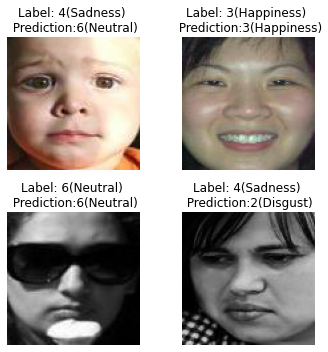

In [33]:
# calling the EmotionRecognition function
test_labels_folderpath  = 'CW_Dataset/labels/list_label_test.txt'
EmotionRecognition(test_labels_folderpath)
